<a href="https://colab.research.google.com/github/Seng-Pan/testingforSimboloAI/blob/main/Time_Series_Forecasting_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 2. Data Preprocessing

In [3]:
ftse100_data = yf.download('^FTSE', start = '2003-01-01', end = '2023-12-31')
ftse100_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-02,3940.399902,4009.500000,3915.800049,4009.500000,4009.500000,824018000
2003-01-03,4009.500000,4027.600098,3991.199951,4005.000000,4005.000000,802181000
2003-01-06,4004.899902,4025.500000,3930.899902,4001.399902,4001.399902,1123294000
2003-01-07,4001.399902,4015.399902,3925.399902,3957.399902,3957.399902,1285890000
2003-01-08,3957.399902,3957.399902,3906.800049,3924.800049,3924.800049,1634166000
...,...,...,...,...,...,...
2023-12-21,7715.700195,7715.700195,7668.399902,7694.700195,7694.700195,603350200
2023-12-22,7694.700195,7715.200195,7676.399902,7697.500000,7697.500000,329604400
2023-12-27,7697.500000,7759.700195,7697.500000,7725.000000,7725.000000,432594200


In [4]:
ftse100_data.dropna(axis = 0, inplace = True)

# Save data to csv file
ftse100_data.to_csv('ftse100.csv')

In [5]:
# Daily returns
ftse100_data['Returns'] = ftse100_data['Close'].pct_change()
ftse100_data

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2003-01-02,3940.399902,4009.500000,3915.800049,4009.500000,4009.500000,824018000,NaN
2003-01-03,4009.500000,4027.600098,3991.199951,4005.000000,4005.000000,802181000,-0.001122
2003-01-06,4004.899902,4025.500000,3930.899902,4001.399902,4001.399902,1123294000,-0.000899
2003-01-07,4001.399902,4015.399902,3925.399902,3957.399902,3957.399902,1285890000,-0.010996
2003-01-08,3957.399902,3957.399902,3906.800049,3924.800049,3924.800049,1634166000,-0.008238
...,...,...,...,...,...,...,...
2023-12-21,7715.700195,7715.700195,7668.399902,7694.700195,7694.700195,603350200,-0.002722
2023-12-22,7694.700195,7715.200195,7676.399902,7697.500000,7697.500000,329604400,0.000364
2023-12-27,7697.500000,7759.700195,7697.500000,7725.000000,7725.000000,432594200,0.003573


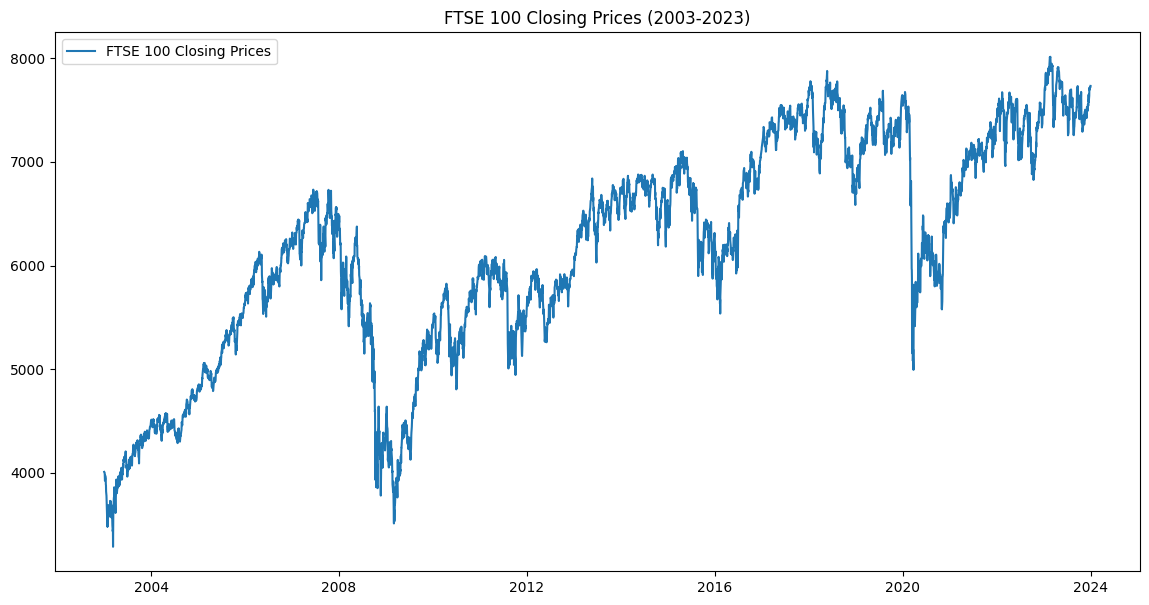

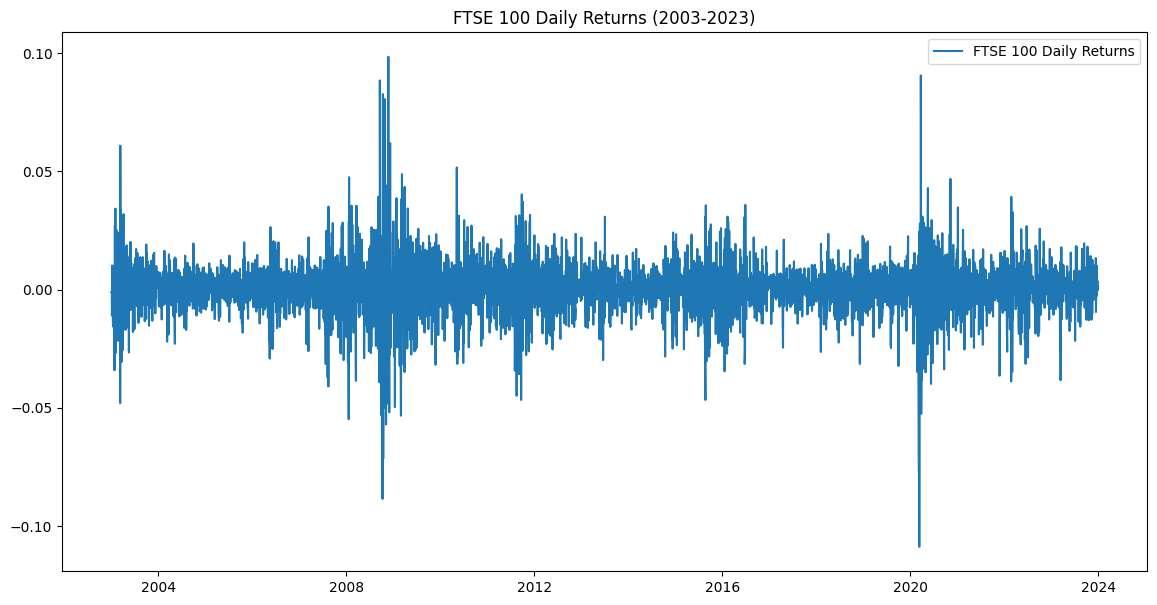

In [6]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(14,7))
plt.plot(ftse100_data['Close'], label='FTSE 100 Closing Prices')
plt.title('FTSE 100 Closing Prices (2003-2023)')
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(ftse100_data['Returns'], label='FTSE 100 Daily Returns')
plt.title('FTSE 100 Daily Returns (2003-2023)')
plt.legend()
plt.show()

### 3-1. Naive forecast for both stock prices and returns

In [18]:
ftse100_data['Returns'] = ftse100_data['Close'].pct_change()

# Split the data into training and testing sets
train_size = int(len(ftse100_data) * 0.7)
train_data, test_data = ftse100_data[:train_size], ftse100_data[train_size:]

In [19]:
train_data

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2003-01-02,3940.399902,4009.500000,3915.800049,4009.500000,4009.500000,824018000,NaN
2003-01-03,4009.500000,4027.600098,3991.199951,4005.000000,4005.000000,802181000,-0.001122
2003-01-06,4004.899902,4025.500000,3930.899902,4001.399902,4001.399902,1123294000,-0.000899
2003-01-07,4001.399902,4015.399902,3925.399902,3957.399902,3957.399902,1285890000,-0.010996
2003-01-08,3957.399902,3957.399902,3906.800049,3924.800049,3924.800049,1634166000,-0.008238
...,...,...,...,...,...,...,...
2017-09-04,7438.500000,7438.500000,7404.100098,7411.500000,7411.500000,389133300,-0.003630
2017-09-05,7411.500000,7437.500000,7369.600098,7372.899902,7372.899902,541337100,-0.005208
2017-09-06,7372.899902,7372.899902,7322.399902,7354.100098,7354.100098,676234700,-0.002550


### NF Data Preprocessing

In [20]:
# (price - X, return - Y)
train_naive_forecast_prices = train_data['Close'].shift(1).dropna()
train_naive_forecast_returns = train_data['Returns'].shift(1).dropna()

In [21]:
train_naive_forecast_prices

,Close
Date,
2003-01-03,4009.500000
2003-01-06,4005.000000
2003-01-07,4001.399902
2003-01-08,3957.399902
2003-01-09,3924.800049
...,...
2017-09-04,7438.500000
2017-09-05,7411.500000
2017-09-06,7372.899902


In [22]:
train_naive_forecast_returns

,Returns
Date,
2003-01-06,-0.001122
2003-01-07,-0.000899
2003-01-08,-0.010996
2003-01-09,-0.008238
2003-01-10,0.002344
...,...
2017-09-04,0.001063
2017-09-05,-0.003630
2017-09-06,-0.005208


### NF Modeling

In [23]:
# for price
train_data_prices = train_data['Close'][1:]
train_rmse_prices = np.sqrt(mean_squared_error(train_data_prices, train_naive_forecast_prices))
print(f'Naive Forecast RMSE (Training Prices): {train_rmse_prices}')

Naive Forecast RMSE (Training Prices): 60.478308588649035


In [24]:
# for return
# filter null values both after using shift
train_data_returns = train_data['Returns'].shift(1).dropna()
train_rmse_returns = np.sqrt(mean_squared_error(train_data_returns, train_naive_forecast_returns))
print(f'Naive Forecast RMSE (Training Returns): {train_rmse_returns}')

Naive Forecast RMSE (Training Returns): 0.0


### NF Evaluation

In [25]:
# Forecast On Last Obeserved Value

# for price
last_observed_price = pd.Series([train_data['Close'].iloc[-1]])
test_naive_forecast_prices = pd.concat([last_observed_price, test_data['Close'][:-1]]).reset_index(drop=True)

# for return
last_observed_return = pd.Series([train_data['Returns'].iloc[-1]])
test_naive_forecast_returns = pd.concat([last_observed_return, test_data['Returns'][:-1]]).reset_index(drop=True)

In [26]:
# Forecast on Testing data

# for pirce
test_rmse_prices = np.sqrt(mean_squared_error(test_data['Close'], test_naive_forecast_prices))
print(f'Naive Forecast RMSE for testing prices: {test_rmse_prices}')

Naive Forecast RMSE for testing prices: 69.65815133160937


In [27]:
# for return
test_rmse_returns = np.sqrt(mean_squared_error(test_data['Returns'][1:], test_naive_forecast_returns[1:]))
print(f'Naive Forecast RMSE for testing returns: {test_rmse_returns}')

Naive Forecast RMSE for testing returns: 0.015042061689509126


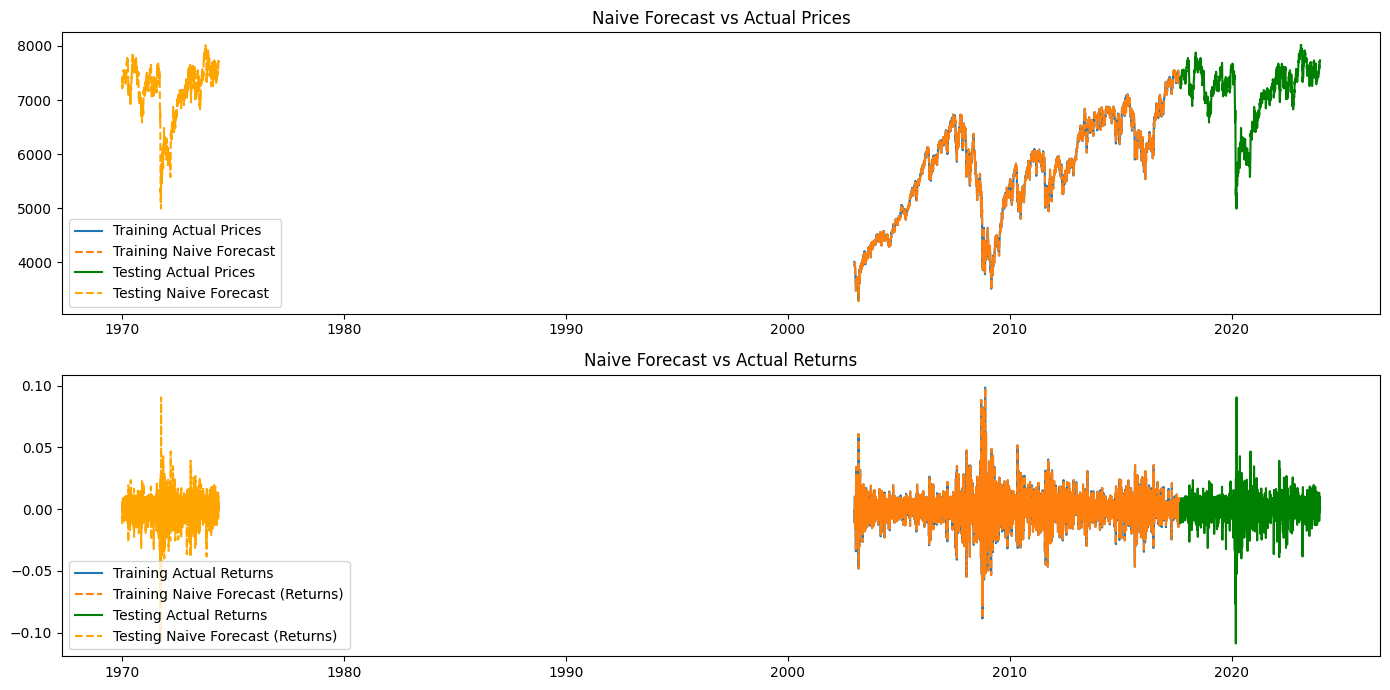

In [28]:
plt.figure(figsize=(14,7))

# Plot actual and forecasted prices
plt.subplot(2, 1, 1)
plt.plot(train_data['Close'], label='Training Actual Prices')
plt.plot(train_naive_forecast_prices, label='Training Naive Forecast', linestyle='--')
plt.plot(test_data['Close'], label='Testing Actual Prices', color='green')
plt.plot(test_naive_forecast_prices, label='Testing Naive Forecast', linestyle='--', color='orange')
plt.title('Naive Forecast vs Actual Prices')
plt.legend()

# Plot actual and forecasted returns
plt.subplot(2, 1, 2)
plt.plot(train_data['Returns'], label='Training Actual Returns')
plt.plot(train_naive_forecast_returns, label='Training Naive Forecast (Returns)', linestyle='--')
plt.plot(test_data['Returns'], label='Testing Actual Returns', color='green')
plt.plot(test_naive_forecast_returns, label='Testing Naive Forecast (Returns)', linestyle='--', color='orange')
plt.title('Naive Forecast vs Actual Returns')
plt.legend()

plt.tight_layout()
plt.show()

### 3-2. Simple Moving Average (SMA)

In [29]:
window_size = 5

# SMA for price
train_data.loc[:, 'SMA_Prices'] = train_data['Close'].rolling(window=window_size).mean()
# SMA for price test data
combined_prices = pd.concat([train_data['Close'].iloc[-window_size:], test_data['Close']])
test_data.loc[:, 'SMA_Prices'] = combined_prices.rolling(window=window_size).mean()

# SMA for returns
train_data.loc[:, 'SMA_Returns'] = train_data['Returns'].rolling(window=window_size).mean()
# SMA return test data
combined_returns = pd.concat([train_data['Returns'].iloc[-window_size:], test_data['Returns']])
test_data.loc[:, 'SMA_Returns'] = combined_returns.rolling(window=window_size).mean()

<ipython-input-29-74a22b495dd7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'SMA_Prices'] = train_data['Close'].rolling(window=window_size).mean()
<ipython-input-29-74a22b495dd7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'SMA_Prices'] = combined_prices.rolling(window=window_size).mean()
<ipython-input-29-74a22b495dd7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [30]:
#  Evaluation
# Forecasting prices using SMA
train_data_prices = train_data['Close'][window_size:]
train_sma_forecast_prices = train_data['SMA_Prices'][window_size:]

train_rmse_prices = np.sqrt(mean_squared_error(train_data_prices, train_sma_forecast_prices))
print(f'SMA RMSE (Training Prices): {train_rmse_prices}')

SMA RMSE (Training Prices): 63.641046303266435


In [31]:
# Forecasting returns using SMA
train_data_returns = train_data['Returns'][window_size:]
train_sma_forecast_returns = train_data['SMA_Returns'][window_size:]

train_rmse_returns = np.sqrt(mean_squared_error(train_data_returns, train_sma_forecast_returns))
print(f'SMA RMSE (Training Returns): {train_rmse_returns}')

SMA RMSE (Training Returns): 0.010272815597014394


In [32]:
# Forecast on testing data
test_rmse_prices = np.sqrt(mean_squared_error(test_data['Close'][window_size:], test_data['SMA_Prices'][window_size:]))
print(f'SMA RMSE for Testing Prices: {test_rmse_prices}')

SMA RMSE for Testing Prices: 75.36032428378661


In [33]:
test_rmse_returns = np.sqrt(mean_squared_error(test_data['Returns'][window_size:], test_data['SMA_Returns'][window_size:]))
print(f'SMA RMSE for Testing Returns: {test_rmse_returns}')

SMA RMSE for Testing Returns: 0.009349602760584212


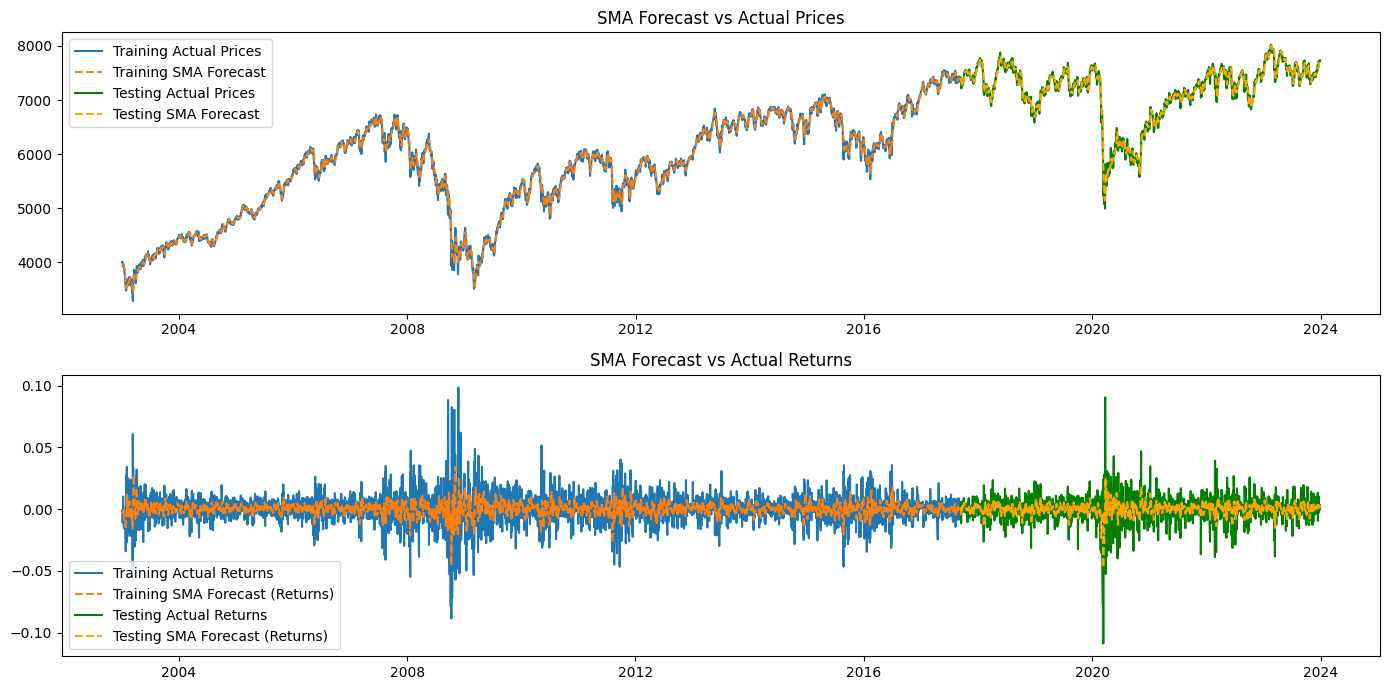

In [34]:
# Plotting

plt.figure(figsize=(14, 7))

# Plot actual and forecasted prices
plt.subplot(2, 1, 1)
plt.plot(train_data['Close'], label='Training Actual Prices')
plt.plot(train_data['SMA_Prices'], label='Training SMA Forecast', linestyle='--')
plt.plot(test_data['Close'], label='Testing Actual Prices', color='green')
plt.plot(test_data['SMA_Prices'], label='Testing SMA Forecast', linestyle='--', color='orange')
plt.title('SMA Forecast vs Actual Prices')
plt.legend()

# Plot actual and forecasted returns
plt.subplot(2, 1, 2)
plt.plot(train_data['Returns'], label='Training Actual Returns')
plt.plot(train_data['SMA_Returns'], label='Training SMA Forecast (Returns)', linestyle='--')
plt.plot(test_data['Returns'], label='Testing Actual Returns', color='green')
plt.plot(test_data['SMA_Returns'], label='Testing SMA Forecast (Returns)', linestyle='--', color='orange')
plt.title('SMA Forecast vs Actual Returns')
plt.legend()

plt.tight_layout()
plt.show()

### 3-3. Exponentially Weighted Moving Average (EWMA)

In [35]:
span = 5

# EWMA for price
train_data['EWMA_Prices'] = train_data['Close'].ewm(span=span, adjust=False).mean()
test_data['EWMA_Prices'] = pd.concat([train_data['Close'].iloc[-span:], test_data['Close']]).ewm(span=span, adjust=False).mean()

# EWMA for returns
train_data['EWMA_Returns'] = train_data['Returns'].ewm(span=span, adjust=False).mean()
test_data['EWMA_Returns'] = pd.concat([train_data['Returns'].iloc[-span:], test_data['Returns']]).ewm(span=span, adjust=False).mean()

<ipython-input-35-613ffcac8893>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['EWMA_Prices'] = train_data['Close'].ewm(span=span, adjust=False).mean()
<ipython-input-35-613ffcac8893>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['EWMA_Prices'] = pd.concat([train_data['Close'].iloc[-span:], test_data['Close']]).ewm(span=span, adjust=False).mean()
<ipython-input-35-613ffcac8893>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [36]:
# Evaluation
# Forecasting prices using ewma
train_rmse_prices = np.sqrt(mean_squared_error(train_data['Close'], train_data['EWMA_Prices']))
print(f'EWMA RMSE (Training Prices): {train_rmse_prices}')

EWMA RMSE (Training Prices): 51.24721675013196


In [37]:
# Forecasting returns using ewma
train_rmse_returns = np.sqrt(mean_squared_error(train_data['Returns'].dropna(), train_data['EWMA_Returns'].dropna()))
print(f'EWMA RMSE (Training Returns): {train_rmse_returns}')

EWMA RMSE (Training Returns): 0.008475321867517347


In [38]:
# Forecast on testing data
test_rmse_prices = np.sqrt(mean_squared_error(test_data['Close'].iloc[span:], test_data['EWMA_Prices'].iloc[span:]))
print(f'EWMA RMSE for Testing Prices: {test_rmse_prices}')

EWMA RMSE for Testing Prices: 61.86102561179645


In [39]:
test_rmse_returns = np.sqrt(mean_squared_error(test_data['Returns'].iloc[span:], test_data['EWMA_Returns'].iloc[span:]))
print(f'EWMA RMSE for Testing Returns: {test_rmse_returns}')

EWMA RMSE for Testing Returns: 0.007680391542070925


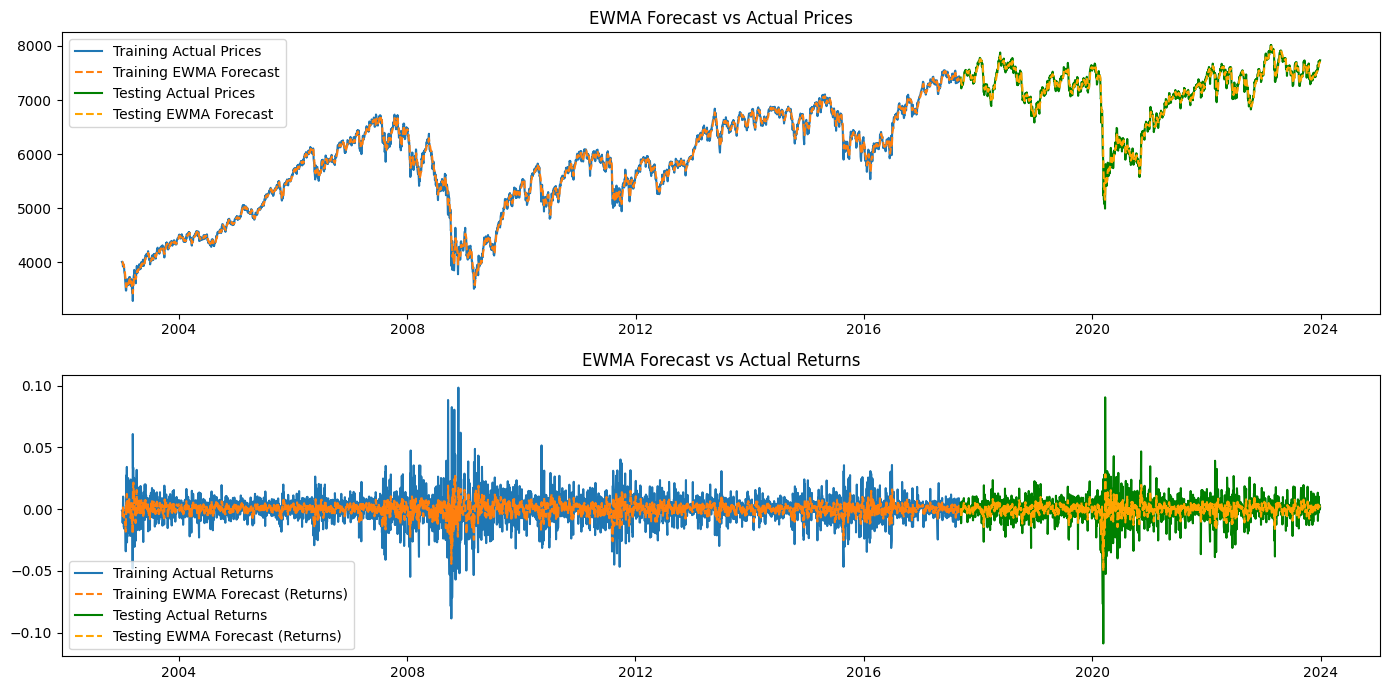

In [40]:
# Plotting

plt.figure(figsize=(14, 7))

# Plot actual and forecasted prices
plt.subplot(2, 1, 1)
plt.plot(train_data['Close'], label='Training Actual Prices')
plt.plot(train_data['EWMA_Prices'], label='Training EWMA Forecast', linestyle='--')
plt.plot(test_data['Close'], label='Testing Actual Prices', color='green')
plt.plot(test_data['EWMA_Prices'], label='Testing EWMA Forecast', linestyle='--', color='orange')
plt.title('EWMA Forecast vs Actual Prices')
plt.legend()

# Plot actual and forecasted returns
plt.subplot(2, 1, 2)
plt.plot(train_data['Returns'], label='Training Actual Returns')
plt.plot(train_data['EWMA_Returns'], label='Training EWMA Forecast (Returns)', linestyle='--')
plt.plot(test_data['Returns'], label='Testing Actual Returns', color='green')
plt.plot(test_data['EWMA_Returns'], label='Testing EWMA Forecast (Returns)', linestyle='--', color='orange')
plt.title('EWMA Forecast vs Actual Returns')
plt.legend()

plt.tight_layout()
plt.show()

### 4. Holt-Winters Model

In [41]:
# checking raw data

print(train_data['Close'].head(10))
print(train_data['Close'].isna().sum())

Date
2003-01-02    4009.500000
2003-01-03    4005.000000
2003-01-06    4001.399902
2003-01-07    3957.399902
2003-01-08    3924.800049
2003-01-09    3934.000000
2003-01-10    3974.100098
2003-01-13    3948.300049
2003-01-14    3945.600098
2003-01-15    3887.800049
Name: Close, dtype: float64
0


In [42]:
# Checking data for null values
print("Valid observations in training data:", train_data['Close'].notna().sum())

Valid observations in training data: 3712


In [59]:
# Modeling
# Adjusting model parameter to produce valid forecasts
hw_model = ExponentialSmoothing(train_data['Close'], trend='add', seasonal=None)
hw_fit = hw_model.fit()
train_data['HW_Trend'] = hw_fit.fittedvalues

test_data['HW_Trend'] = hw_fit.forecast(len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-59-b033f61e8c86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['HW_Trend'] = hw_fit.fittedvalues
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version

In [60]:
print("Basic Holt-Winters Predictions:\n", test_data['HW_Trend'].head(15))

Basic Holt-Winters Predictions:
 Date
2017-09-11   NaN
2017-09-12   NaN
2017-09-13   NaN
2017-09-14   NaN
2017-09-15   NaN
2017-09-18   NaN
2017-09-19   NaN
2017-09-20   NaN
2017-09-21   NaN
2017-09-22   NaN
2017-09-25   NaN
2017-09-26   NaN
2017-09-27   NaN
2017-09-28   NaN
2017-09-29   NaN
Name: HW_Trend, dtype: float64


In [62]:
# After adjusting, use for seasonal component
# Additive
hw_additive_model = ExponentialSmoothing(train_data['Close'], trend='add', seasonal='add', seasonal_periods=30)  # Adjust seasonal_periods accordingly
hw_additive_fit = hw_additive_model.fit()
train_data['HW_Additive'] = hw_additive_fit.fittedvalues
test_data['HW_Additive'] = hw_additive_fit.forecast(len(test_data))

# Multiplicative
hw_multiplicative_model = ExponentialSmoothing(train_data['Close'], trend='add', seasonal='mul', seasonal_periods=30)
hw_multiplicative_fit = hw_multiplicative_model.fit()
train_data['HW_Multiplicative'] = hw_multiplicative_fit.fittedvalues
test_data['HW_Multiplicative'] = hw_multiplicative_fit.forecast(len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-62-78a16b0b3259>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['HW_Additive'] = hw_additive_fit.fittedvalues
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `st

In [63]:
print("Holt-Winters Additive Predictions:\n", test_data['HW_Additive'].head(15))
print("Holt-Winters Multiplicative Predictions:\n", test_data['HW_Multiplicative'].head(15))

Holt-Winters Additive Predictions:
 Date
2017-09-11   NaN
2017-09-12   NaN
2017-09-13   NaN
2017-09-14   NaN
2017-09-15   NaN
2017-09-18   NaN
2017-09-19   NaN
2017-09-20   NaN
2017-09-21   NaN
2017-09-22   NaN
2017-09-25   NaN
2017-09-26   NaN
2017-09-27   NaN
2017-09-28   NaN
2017-09-29   NaN
Name: HW_Additive, dtype: float64
Holt-Winters Multiplicative Predictions:
 Date
2017-09-11   NaN
2017-09-12   NaN
2017-09-13   NaN
2017-09-14   NaN
2017-09-15   NaN
2017-09-18   NaN
2017-09-19   NaN
2017-09-20   NaN
2017-09-21   NaN
2017-09-22   NaN
2017-09-25   NaN
2017-09-26   NaN
2017-09-27   NaN
2017-09-28   NaN
2017-09-29   NaN
Name: HW_Multiplicative, dtype: float64


In [64]:
# Evaluation for Additive Model
train_rmse_additive = np.sqrt(mean_squared_error(train_data['Close'], train_data['HW_Additive']))
train_mae_additive = mean_absolute_error(train_data['Close'], train_data['HW_Additive'])

print(f'Holt-Winters Additive RMSE (Training Prices): {train_rmse_additive}')
print(f'Holt-Winters Additive MAE (Training Prices): {train_mae_additive}')

Holt-Winters Additive RMSE (Training Prices): 63.46246375344397
Holt-Winters Additive MAE (Training Prices): 46.55836537627745


In [65]:
# Evaluation for Multiplicative Model
train_rmse_multiplicative = np.sqrt(mean_squared_error(train_data['Close'], train_data['HW_Multiplicative']))
train_mae_multiplicative = mean_absolute_error(train_data['Close'], train_data['HW_Multiplicative'])

print(f'Holt-Winters Multiplicative RMSE (Training Prices): {train_rmse_multiplicative}')
print(f'Holt-Winters Multiplicative MAE (Training Prices): {train_mae_multiplicative}')

Holt-Winters Multiplicative RMSE (Training Prices): 65.39108625286893
Holt-Winters Multiplicative MAE (Training Prices): 48.53003084058407


In [66]:
# Evaluation on Testing Data

# Check null values
print("NaN values in test_data['Close']:", test_data['Close'].isna().sum())
print("NaN values in test_data['HW_Additive']:", test_data['HW_Additive'].isna().sum())
print("NaN values in test_data['HW_Multiplicative']:", test_data['HW_Multiplicative'].isna().sum())

NaN values in test_data['Close']: 0
NaN values in test_data['HW_Additive']: 1591
NaN values in test_data['HW_Multiplicative']: 1591


In [67]:
print(test_data[['Close', 'HW_Additive', 'HW_Multiplicative']].head(15))

                  Close  HW_Additive  HW_Multiplicative
Date                                                   
2017-09-11  7413.600098          NaN                NaN
2017-09-12  7400.700195          NaN                NaN
2017-09-13  7379.700195          NaN                NaN
2017-09-14  7295.399902          NaN                NaN
2017-09-15  7215.500000          NaN                NaN
2017-09-18  7253.299805          NaN                NaN
2017-09-19  7275.299805          NaN                NaN
2017-09-20  7272.000000          NaN                NaN
2017-09-21  7263.899902          NaN                NaN
2017-09-22  7310.600098          NaN                NaN
2017-09-25  7301.299805          NaN                NaN
2017-09-26  7285.700195          NaN                NaN
2017-09-27  7313.500000          NaN                NaN
2017-09-28  7322.799805          NaN                NaN
2017-09-29  7372.799805          NaN                NaN


In [68]:
# filter null values
test_data_aligned = test_data[['Close', 'HW_Additive', 'HW_Multiplicative']].dropna()

In [88]:
# Check if test_data_aligned is empty
if test_data_aligned.empty:
    print("No valid data for RMSE calculation. Please check the input data or model parameters.")
else:
    # RMSE calculations
    test_rmse_additive = np.sqrt(mean_squared_error(test_data_aligned['Close'], test_data_aligned['HW_Additive']))
    test_rmse_multiplicative = np.sqrt(mean_squared_error(test_data_aligned['Close'], test_data_aligned['HW_Multiplicative']))

    # MAE calculations
    test_mae_additive = mean_absolute_error(test_data_aligned['Close'], test_data_aligned['HW_Additive'])
    test_mae_multiplicative = mean_absolute_error(test_data_aligned['Close'], test_data_aligned['HW_Multiplicative'])

    print(f'Holt-Winters Additive RMSE for Testing Prices: {test_rmse_additive}')
    print(f'Holt-Winters Multiplicative RMSE for Testing Prices: {test_rmse_multiplicative}')

    print(f'Holt-Winters Additive MAE for Testing Prices: {test_mae_additive}')
    print(f'Holt-Winters Multiplicative MAE for Testing Prices: {test_mae_multiplicative}')

No valid data for RMSE calculation. Please check the input data or model parameters.


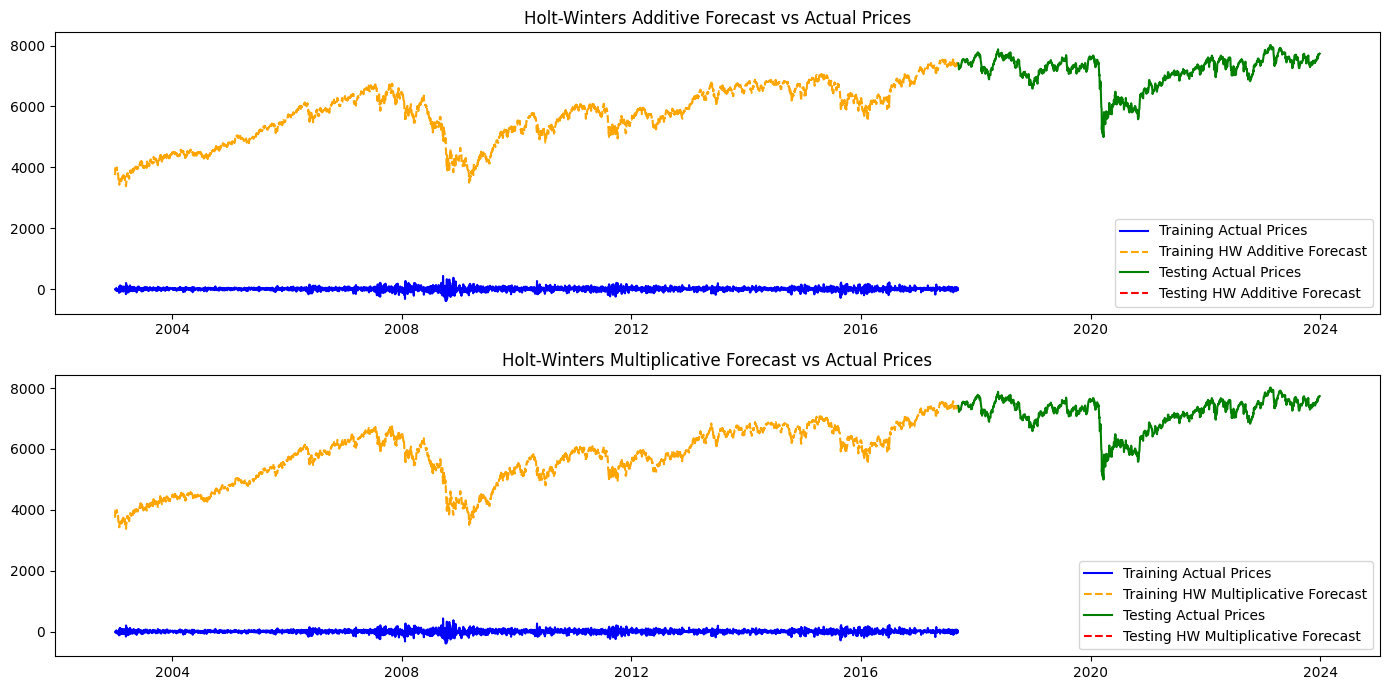

In [89]:
# Plotting

plt.figure(figsize=(14, 7))

# Plot actual and forecasted prices for Additive Model
plt.subplot(2, 1, 1)
plt.plot(train_data['Close'], label='Training Actual Prices', color='blue')
plt.plot(train_data['HW_Additive'], label='Training HW Additive Forecast', linestyle='--', color='orange')
plt.plot(test_data['Close'], label='Testing Actual Prices', color='green')
plt.plot(test_data['HW_Additive'], label='Testing HW Additive Forecast', linestyle='--', color='red')
plt.title('Holt-Winters Additive Forecast vs Actual Prices')
plt.legend()

# Plot actual and forecasted prices for Multiplicative Model
plt.subplot(2, 1, 2)
plt.plot(train_data['Close'], label='Training Actual Prices', color='blue')
plt.plot(train_data['HW_Multiplicative'], label='Training HW Multiplicative Forecast', linestyle='--', color='orange')
plt.plot(test_data['Close'], label='Testing Actual Prices', color='green')
plt.plot(test_data['HW_Multiplicative'], label='Testing HW Multiplicative Forecast', linestyle='--', color='red')
plt.title('Holt-Winters Multiplicative Forecast vs Actual Prices')
plt.legend()

plt.tight_layout()
plt.show()

### 5. ARIMA Model

In [ ]:
# Check stationarity
def check_stationarity(series):
    result = adfuller(series)
    print(f'Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1] < 0.05  # If p-value < 0.05, reject the null hypothesis

In [72]:
stationary_close = check_stationarity(train_data['Close'].dropna())
stationary_close

Statistic: -1.814125692773982
p-value: 0.37347157288731136


False

In [73]:
stationary_returns = check_stationarity(train_data['Returns'].dropna())
stationary_returns

Statistic: -12.813052695600911
p-value: 6.3855995907042336e-24


True

In [74]:
# Differencing
d = 0
while not stationary_close:
    train_data['Close'] = train_data['Close'].diff().dropna()
    d += 1
    stationary_close = check_stationarity(train_data['Close'].dropna())

print(f'Differencing (d) for prices: {d}')

Statistic: -29.34605013370106
p-value: 0.0
Differencing (d) for prices: 1


<ipython-input-74-8ec84be7fc6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close'] = train_data['Close'].diff().dropna()


In [75]:
d_returns = 0
while not stationary_returns:
    train_data['Returns'] = train_data['Returns'].diff().dropna()
    d_returns += 1
    stationary_returns = check_stationarity(train_data['Returns'].dropna())

print(f'Differencing order (d) for Returns: {d_returns}')

Differencing order (d) for Returns: 0


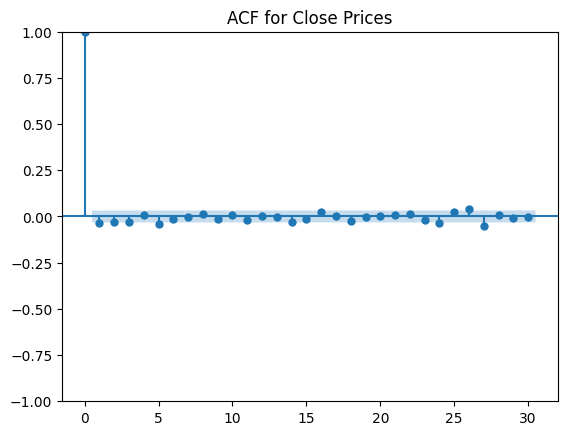

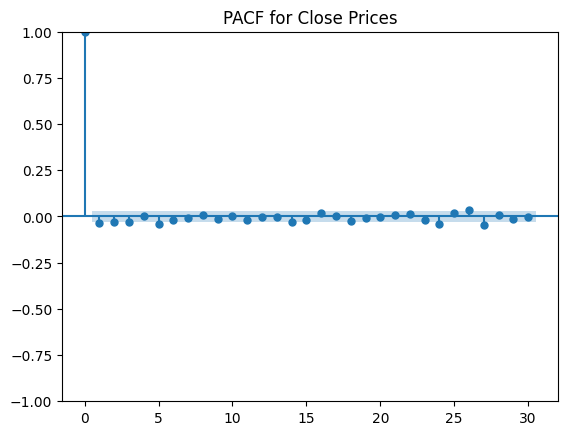

In [76]:
# ACF and PACF plots for p and q of Close Price
plot_acf(train_data['Close'].dropna(), lags=30)
plt.title('ACF for Close Prices')
plt.show()

plot_pacf(train_data['Close'].dropna(), lags=30)
plt.title('PACF for Close Prices')
plt.show()

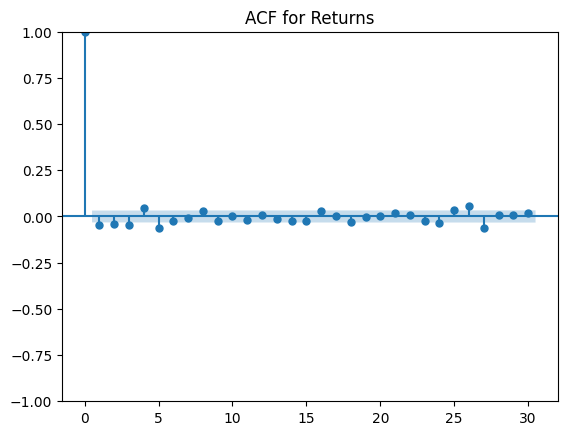

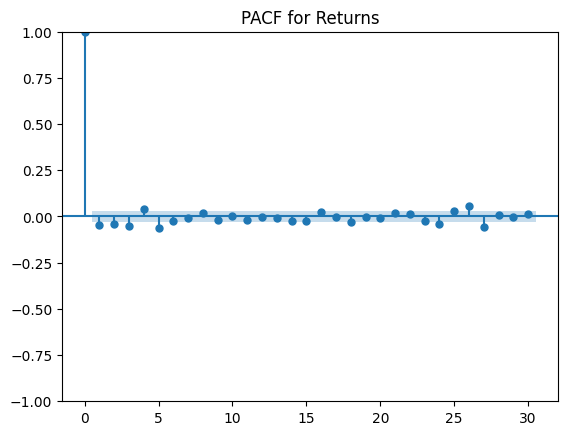

In [77]:
# ACF and PACF plots for Returns
plot_acf(train_data['Returns'].dropna(), lags=30)
plt.title('ACF for Returns')
plt.show()

plot_pacf(train_data['Returns'].dropna(), lags=30)
plt.title('PACF for Returns')
plt.show()

In [78]:
# Modeling

# Fit ARIMA model for Closing Prices
p = 1  # p based on PACF
q = 1  # q based on ACF

model_close = ARIMA(train_data['Close'].dropna(), order=(p, d, q))
model_close_fit = model_close.fit()
print(model_close_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3711
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20485.450
Date:                Sun, 20 Oct 2024   AIC                          40976.901
Time:                        17:14:15   BIC                          40995.557
Sample:                             0   HQIC                         40983.539
                               - 3711                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0367      0.011     -3.281      0.001      -0.059      -0.015
ma.L1         -0.9999      0.005   -188.580      0.000      -1.010      -0.989
sigma2      3653.2206     50.705     72.049      0.0

In [91]:
# Fit ARIMA model for Returns

p_returns = 1
q_returns = 1

model_returns = ARIMA(train_data['Returns'].dropna(), order=(p_returns, d_returns, q_returns))
model_returns_fit = model_returns.fit()
print(model_returns_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 3711
Model:                 ARIMA(1, 0, 1)   Log Likelihood               11332.208
Date:                Sun, 20 Oct 2024   AIC                         -22656.417
Time:                        17:25:41   BIC                         -22631.541
Sample:                             0   HQIC                        -22647.565
                               - 3711                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.221      0.222      -0.000       0.001
ar.L1         -0.0231      0.186     -0.124      0.901      -0.388       0.341
ma.L1         -0.0231      0.186     -0.124      0.9

In [92]:
# Evaluation

# Forecast for Close prices
forecast_close = model_close_fit.forecast(steps=len(test_data))
# forecast_close.shape
forecast_index = test_data.index[:len(forecast_close)]
test_data.loc[forecast_index,'ARIMA_Close'] = forecast_close


# Check RMSE for Closing Prices
valid_data = test_data[['Close', 'ARIMA_Close']].dropna()  # Filter NaN values
if not valid_data.empty:
    test_rmse_close = np.sqrt(mean_squared_error(valid_data['Close'], valid_data['ARIMA_Close']))
    test_mae_close = mean_absolute_error(valid_data['Close'], valid_data['ARIMA_Close'])
    print(f'ARIMA RMSE for Testing Prices: {test_rmse_close}')
    print(f'ARIMA MAE for Testing Prices: {test_mae_close}')
else:
    print("No valid data for RMSE calculation. Please check the input data or model parameters.")

No valid data for RMSE calculation. Please check the input data or model parameters.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [94]:
# Forecast for returns
forecast_returns = model_returns_fit.forecast(steps=len(test_data))
# forecast_close.shape
forecast_index = test_data.index[:len(forecast_returns)]
test_data.loc[forecast_index,'ARIMA_Returns'] = forecast_returns


# Check RMSE for Closing Prices
valid_data = test_data[['Returns', 'ARIMA_Returns']].dropna()  # Filter NaN values
if not valid_data.empty:
    test_rmse_returns = np.sqrt(mean_squared_error(valid_data['Returns'], valid_data['ARIMA_Returns']))
    test_mae_returns = mean_absolute_error(valid_data['Returns'], valid_data['ARIMA_Returns'])
    print(f'ARIMA RMSE for Testing Returns: {test_rmse_returns}')
    print(f'ARIMA MAE for Testing Returns: {test_mae_returns}')
else:
    print("No valid data for RMSE calculation. Please check the input data or model parameters.")

No valid data for RMSE calculation. Please check the input data or model parameters.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


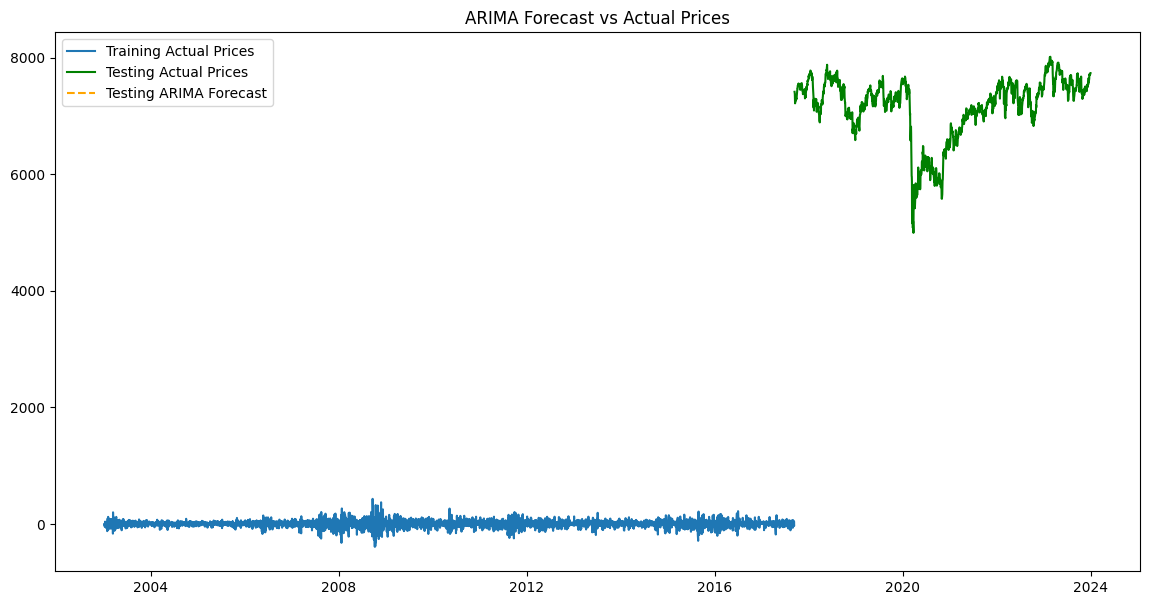

In [95]:
# Plotting

plt.figure(figsize=(14, 7))

# Plot actual vs forecasted Closing Prices
plt.plot(train_data['Close'], label='Training Actual Prices')
plt.plot(test_data['Close'], label='Testing Actual Prices', color='green')
plt.plot(test_data['ARIMA_Close'], label='Testing ARIMA Forecast', linestyle='--', color='orange')
plt.title('ARIMA Forecast vs Actual Prices')
plt.legend()

plt.show()

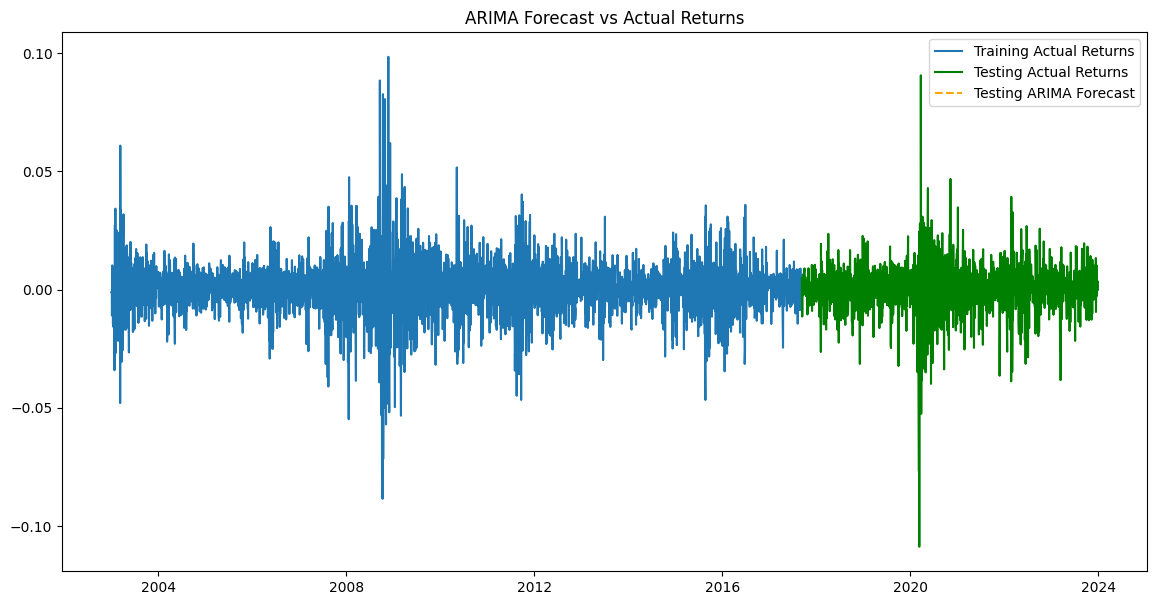

In [96]:
plt.figure(figsize=(14, 7))

# Plot actual vs forecasted Returns
plt.plot(train_data['Returns'], label='Training Actual Returns')
plt.plot(test_data['Returns'], label='Testing Actual Returns', color='green')
plt.plot(test_data['ARIMA_Returns'], label='Testing ARIMA Forecast', linestyle='--', color='orange')
plt.title('ARIMA Forecast vs Actual Returns')
plt.legend()
plt.show()

## 7. ARIMAX Model


In [97]:
# Download S&P 500 data as an exogenous variable
sp500_data = yf.download('^GSPC', start='2003-01-01', end='2023-12-31')

# Download GBP/USD exchange rate as another exogenous variable
gbp_usd_data = yf.download('GBPUSD=X', start='2003-01-01', end='2023-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [98]:
sp500_data['Returns'] = sp500_data['Close'].pct_change()
gbp_usd_data['Returns'] = gbp_usd_data['Close'].pct_change()

In [99]:
# Align the datasets by date
data = pd.DataFrame({
    'FTSE_Close': ftse100_data['Close'],
    'FTSE_Returns': ftse100_data['Returns'],
    'SP500_Returns': sp500_data['Returns'],
    'GBPUSD_Returns': gbp_usd_data['Returns']
}).dropna()

# Convert index to datetime
data.index = pd.to_datetime(data.index)


In [100]:
# Differencing FTSE 100 prices to make them stationary
data['FTSE_Close_Diff'] = data['FTSE_Close'].diff().dropna()

# Define endogenous (differenced prices) and exogenous variables
endog_prices = data['FTSE_Close_Diff'].dropna()
exog_prices = data[['SP500_Returns', 'GBPUSD_Returns']].loc[endog_prices.index]

In [101]:
split_index = int(len(endog_prices) * 0.7)

# Split the data into training and testing datasets
arimax_train_endog_prices = endog_prices[:split_index]
arimax_test_endog_prices = endog_prices[split_index:]

arimax_train_exog_prices = exog_prices[:split_index]
arimax_test_exog_prices = exog_prices[split_index:]

In [102]:
# Use the last price from the training set to re-integrate the differenced forecast
last_train_price = ftse100_data['Close'].iloc[split_index-1]

# Fit ARIMAX model to training data
arimax_model = sm.tsa.ARIMA(arimax_train_endog_prices, exog=arimax_train_exog_prices, order=(1, 1, 1))
arimax_result = arimax_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [103]:
train_data = pd.DataFrame({
    'FTSE_Close_Diff': arimax_train_endog_prices,
    'SP500_Returns': arimax_train_exog_prices['SP500_Returns'],
    'GBPUSD_Returns': arimax_train_exog_prices['GBPUSD_Returns']
})


test_data = pd.DataFrame({
    'FTSE_Close_Diff': arimax_test_endog_prices,
    'SP500_Returns': arimax_test_exog_prices['SP500_Returns'],
    'GBPUSD_Returns': arimax_test_exog_prices['GBPUSD_Returns']
})



In [104]:
# Define the order of ARIMAX (p, d, q)
arima_order = (1, 1, 1)

# Fit ARIMAX model to training data
arimax_model = sm.tsa.ARIMA(arimax_train_endog_prices, exog=arimax_train_exog_prices, order=arima_order)
arimax_result = arimax_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [105]:
# Forecast for the test set
forecast_steps = len(arimax_test_endog_prices)
forecast_result = arimax_result.get_forecast(steps=forecast_steps, exog=arimax_test_exog_prices)

# Get forecasted mean values for differenced prices
forecasted_diff_prices = forecast_result.predicted_mean

# Reintegrate forecasted differenced prices to get actual prices
last_train_price = ftse100_data['Close'].iloc[split_index-1]
forecasted_prices = np.cumsum(forecasted_diff_prices) + last_train_price

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [106]:
# Calculate RMSE and MAE for prices
rmse_prices = np.sqrt(mean_squared_error(ftse100_data['Close'].iloc[split_index:split_index + forecast_steps], forecasted_prices))
mae_prices = mean_absolute_error(ftse100_data['Close'].iloc[split_index:split_index + len(forecasted_prices)], forecasted_prices)

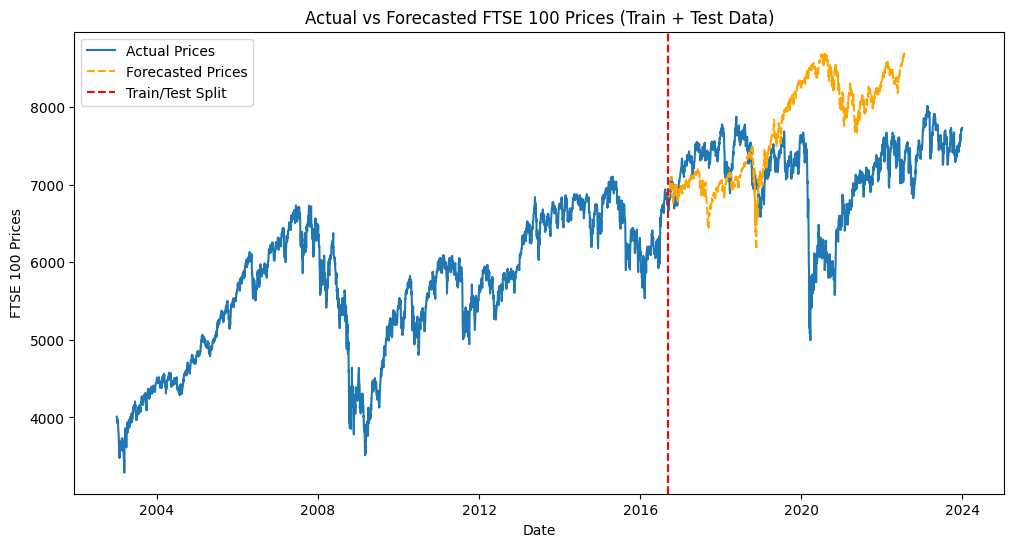

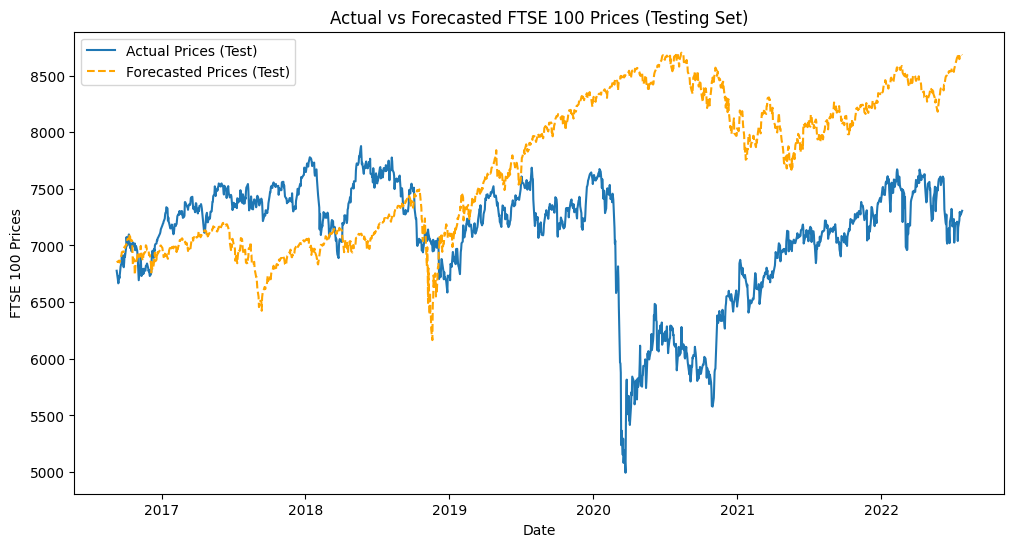

RMSE for Prices: 1152.0684450246845
MAE for Forecasted Prices: 879.7412434948578


In [107]:
# Plot Actual prices (both training and testing)
plt.figure(figsize=(12, 6))
plt.plot(ftse100_data['Close'], label='Actual Prices')

# Plot forecasted prices only for the test set with the correct length
plt.plot(ftse100_data.index[split_index:split_index + len(forecasted_prices)], forecasted_prices,
         label='Forecasted Prices', linestyle='--', color='orange')

# Add a dashed vertical line to indicate the train/test split
plt.axvline(x=ftse100_data.index[split_index], color='red', linestyle='--', label='Train/Test Split')

# Add labels and legend
plt.title('Actual vs Forecasted FTSE 100 Prices (Train + Test Data)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Prices')
plt.legend()
plt.show()

# Test set only
plt.figure(figsize=(12, 6))
plt.plot(ftse100_data.index[split_index:split_index + len(arimax_test_endog_prices)],
         ftse100_data['Close'].iloc[split_index:split_index + len(arimax_test_endog_prices)],
         label='Actual Prices (Test)')

plt.plot(ftse100_data.index[split_index:split_index + len(forecasted_prices)], forecasted_prices,
         label='Forecasted Prices (Test)', linestyle='--', color='orange')

# Add labels and legend
plt.title('Actual vs Forecasted FTSE 100 Prices (Testing Set)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Prices')
plt.legend()
plt.show()

# Print error metrics
print(f"RMSE for Prices: {rmse_prices}")
print(f"MAE for Forecasted Prices: {mae_prices}")

### ARIMAX Model for Returns


In [108]:
# Use FTSE 100 returns as the endogenous variable
endog_returns = data['FTSE_Returns'].dropna()

# Use S&P 500 and GBP/USD returns as the exogenous variables
exog_returns = data[['SP500_Returns', 'GBPUSD_Returns']].loc[endog_returns.index]

In [109]:
# Now split the returns data into training and test sets
split_index = int(len(endog_returns) * 0.7)

# Training data
arimax_train_endog_returns = endog_returns[:split_index]
arimax_train_exog_returns = exog_returns[:split_index]

# Testing data
arimax_test_endog_returns = endog_returns[split_index:]
arimax_test_exog_returns = exog_returns[split_index:]

In [110]:
arima_order_returns = (1, 0, 1)

# Fit the ARIMAX model for returns
arimax_model_returns = sm.tsa.ARIMA(endog_returns, exog=exog_returns, order=arima_order_returns)
arimax_result_returns = arimax_model_returns.fit()

# Forecast returns for the test set
forecast_steps_returns = len(arimax_test_endog_prices)
forecast_result_returns = arimax_result_returns.get_forecast(steps=forecast_steps_returns, exog=arimax_test_exog_prices)

# Get forecasted returns (mean values)
forecasted_returns = forecast_result_returns.predicted_mean

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

In [111]:
rmse_returns = np.sqrt(mean_squared_error(arimax_test_endog_returns, forecasted_returns))
mae_returns = mean_absolute_error(arimax_test_endog_returns, forecasted_returns)

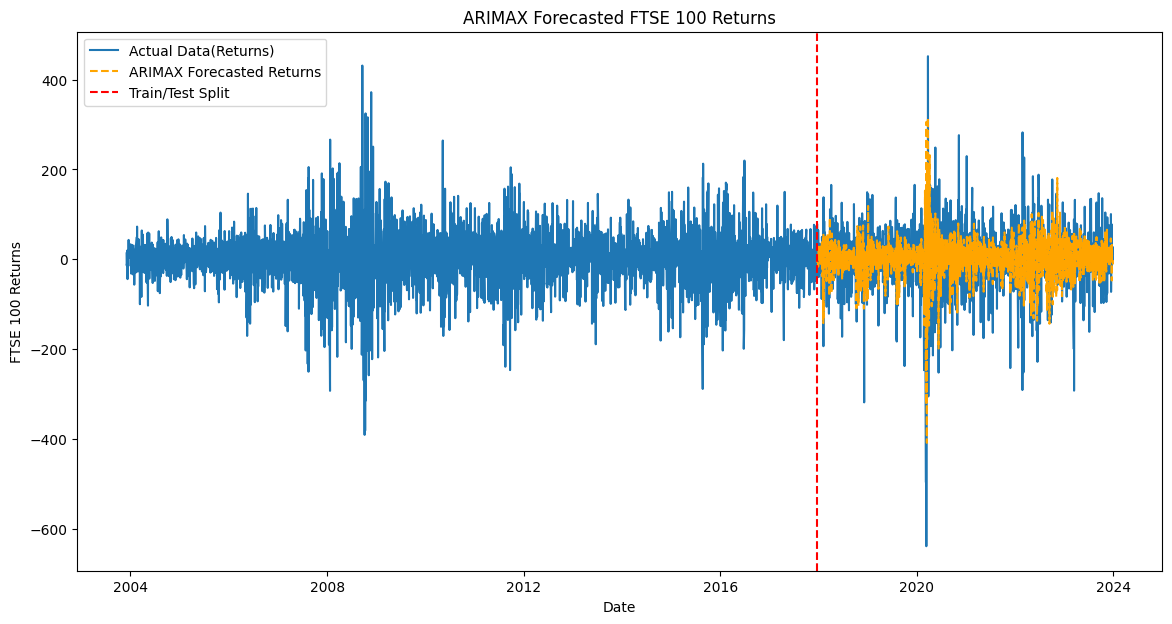

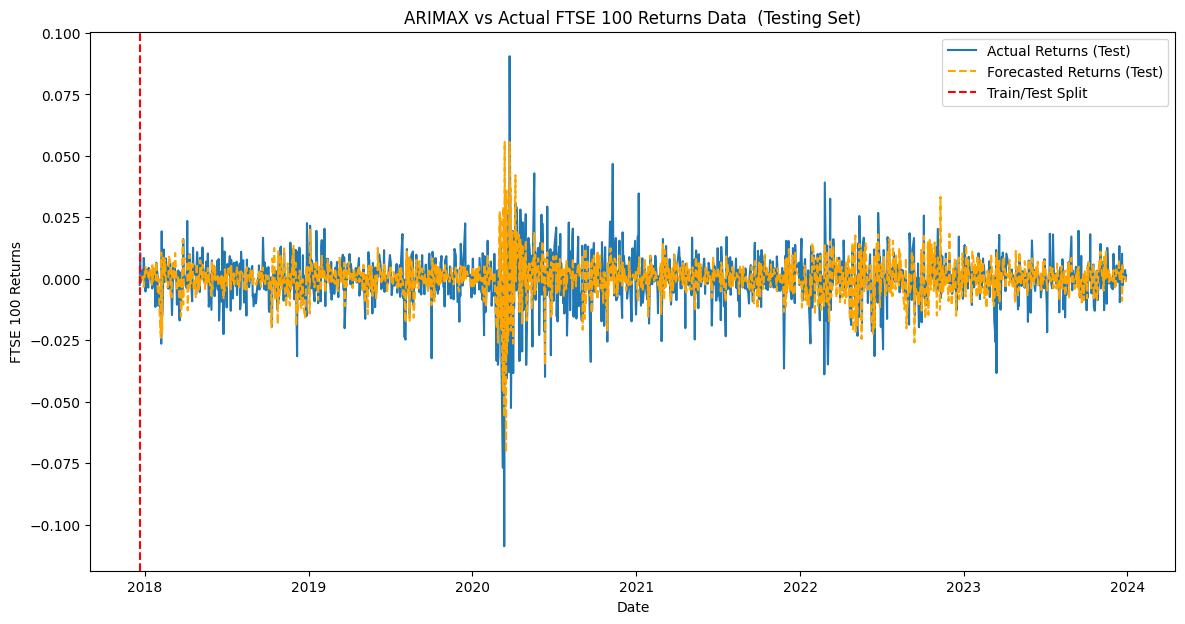

RMSE for Returns: 0.009157225905448589
MAE for Returns: 0.006622638427187142


In [112]:

# Plot the returns (or differenced prices)
plt.figure(figsize=(14, 7))
plt.plot(data['FTSE_Close_Diff'], label='Actual Data(Returns)')
plt.plot(arimax_test_endog_prices.index, forecasted_diff_prices, label='ARIMAX Forecasted Returns', linestyle='--', color='orange')
plt.axvline(x=arimax_test_endog_prices.index[0], color='red', linestyle='--', label='Train/Test Split')

plt.title('ARIMAX Forecasted FTSE 100 Returns')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Returns')
plt.legend()
plt.show()

# Test set only
plt.figure(figsize=(14, 7))
plt.plot(arimax_test_endog_returns.index, arimax_test_endog_returns, label='Actual Returns (Test)')
plt.plot(arimax_test_endog_returns.index, forecasted_returns, label='Forecasted Returns (Test)', linestyle='--', color='orange')
plt.axvline(x=arimax_test_endog_prices.index[0], color='red', linestyle='--', label='Train/Test Split')

# Add labels and legend
plt.title('ARIMAX vs Actual FTSE 100 Returns Data  (Testing Set)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Returns')
plt.legend()
plt.show()

print(f"RMSE for Returns: {rmse_returns}")
print(f"MAE for Returns: {mae_returns}")

## 8. SARIMA Model


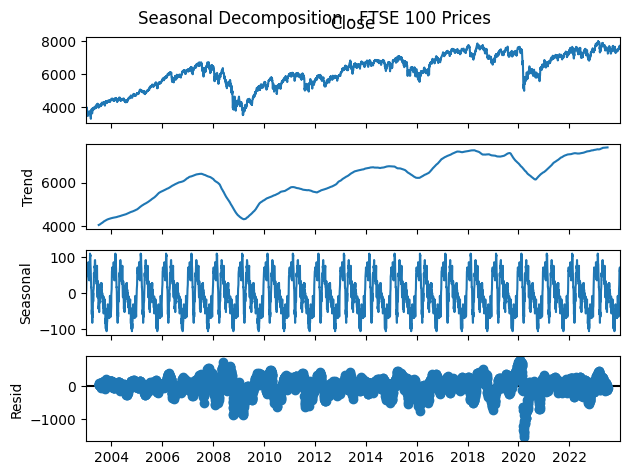

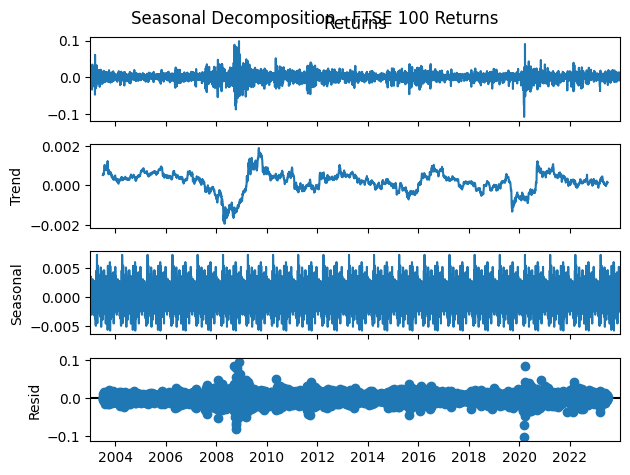

In [113]:
# Use FTSE 100 Closing Prices for SARIMA Model
prices = ftse100_data['Close']
returns = ftse100_data['Returns'].dropna()

# Decompose the closing price data to visualize seasonality (252 trading days in a year)
decomposition_prices = seasonal_decompose(ftse100_data['Close'].dropna(), model='additive', period=252)
decomposition_prices.plot()
plt.suptitle('Seasonal Decomposition - FTSE 100 Prices')
plt.show()

# Decompose the return data (assume yearly )
decomposition_returns = seasonal_decompose(ftse100_data['Returns'].dropna(), model='additive', period=252)
decomposition_returns.plot()
plt.suptitle('Seasonal Decomposition - FTSE 100 Returns')
plt.show()


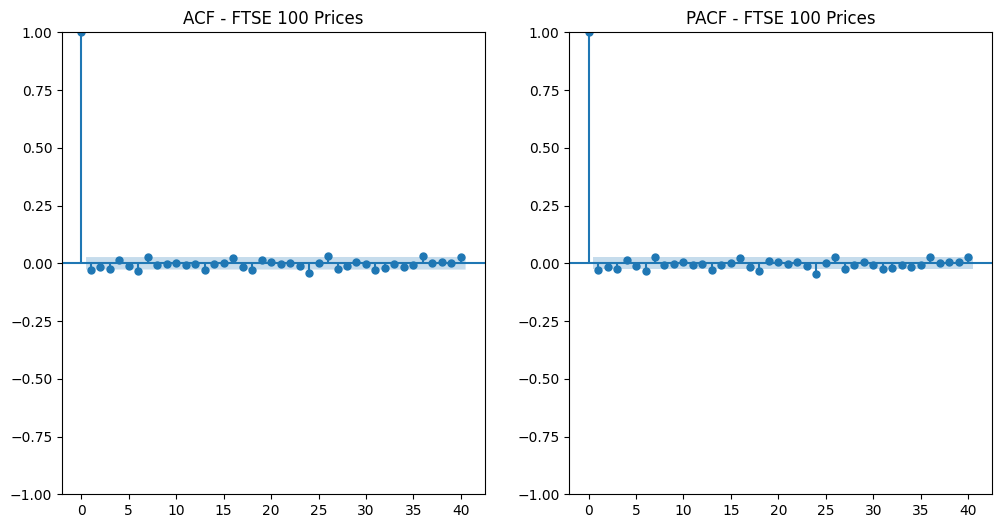

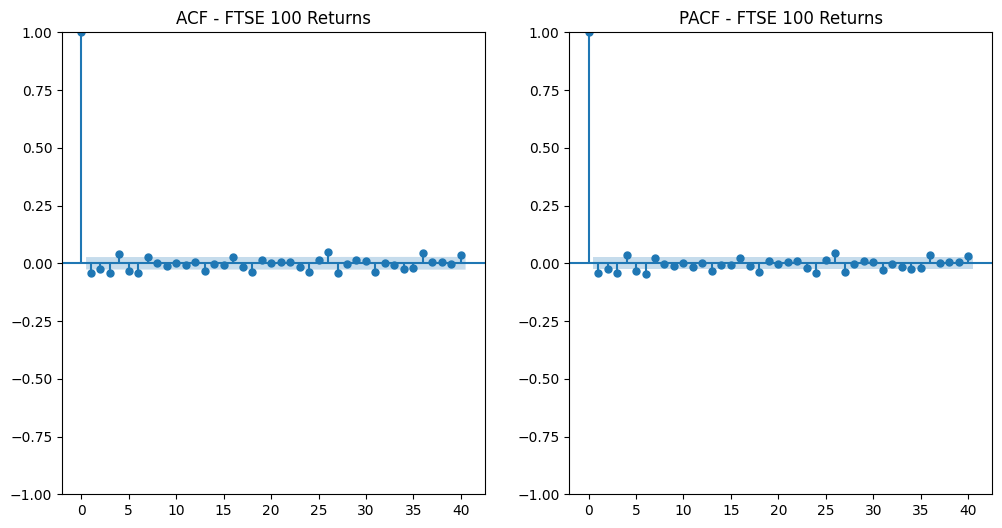

In [114]:
# ACF and PACF for Prices (use differencing to make the series stationary)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(prices.diff().dropna(), lags=40, ax=plt.gca())  # Adjust 'lags' as needed
plt.title('ACF - FTSE 100 Prices')

plt.subplot(122)
plot_pacf(prices.diff().dropna(), lags=40, ax=plt.gca())
plt.title('PACF - FTSE 100 Prices')
plt.show()

# ACF and PACF for Returns
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(returns, lags=40, ax=plt.gca())
plt.title('ACF - FTSE 100 Returns')

plt.subplot(122)
plot_pacf(returns, lags=40, ax=plt.gca())
plt.title('PACF - FTSE 100 Returns')
plt.show()


In [115]:
# Define SARIMA order: (p, d, q) x (P, D, Q, S), where S is the seasonal period
sarima_order = (1, 0, 1)
seasonal_order = (1, 0, 1, 21)  # Seasonal terms

# SARIMA Model for Prices
sarima_model_prices = SARIMAX(prices, order=sarima_order, seasonal_order=seasonal_order)
sarima_result_prices = sarima_model_prices.fit()

# SARIMA Model for Returns
sarima_model_returns = SARIMAX(returns, order=sarima_order, seasonal_order=seasonal_order)
sarima_result_returns = sarima_model_returns.fit()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/

In [116]:
# Forecast next 1,512 trading days (6 years) for Prices
forecast_steps = 1512
forecast_prices = sarima_result_prices.get_forecast(steps=forecast_steps)
forecasted_prices = forecast_prices.predicted_mean

# Forecast next 1,512 trading days (6 years) for Returns
forecast_returns = sarima_result_returns.get_forecast(steps=forecast_steps)
forecasted_returns = forecast_returns.predicted_mean


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [117]:
# Actual prices and returns for the last 6 years (252 days per year)
actual_prices = prices[-forecast_steps:]
actual_returns = returns[-forecast_steps:]

# Evaluation metrics for prices
rmse_prices = np.sqrt(mean_squared_error(actual_prices, forecasted_prices))
mae_prices = mean_absolute_error(actual_prices, forecasted_prices)

In [118]:
# Evaluation metrics for returns
rmse_returns = np.sqrt(mean_squared_error(actual_returns, forecasted_returns))
mae_returns = mean_absolute_error(actual_returns, forecasted_returns)

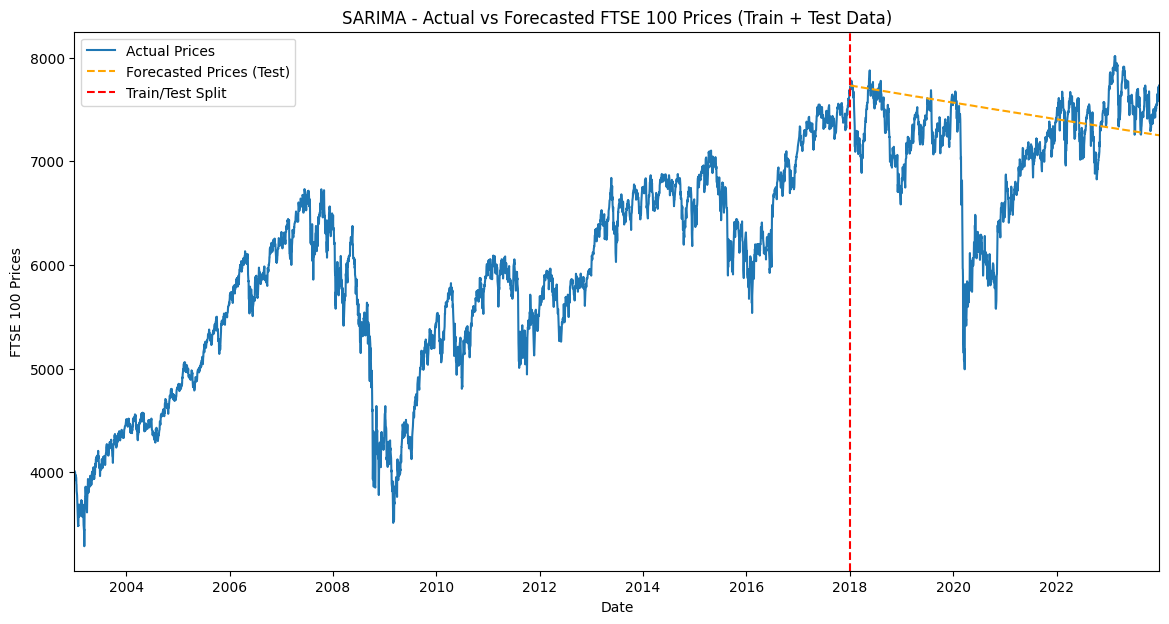

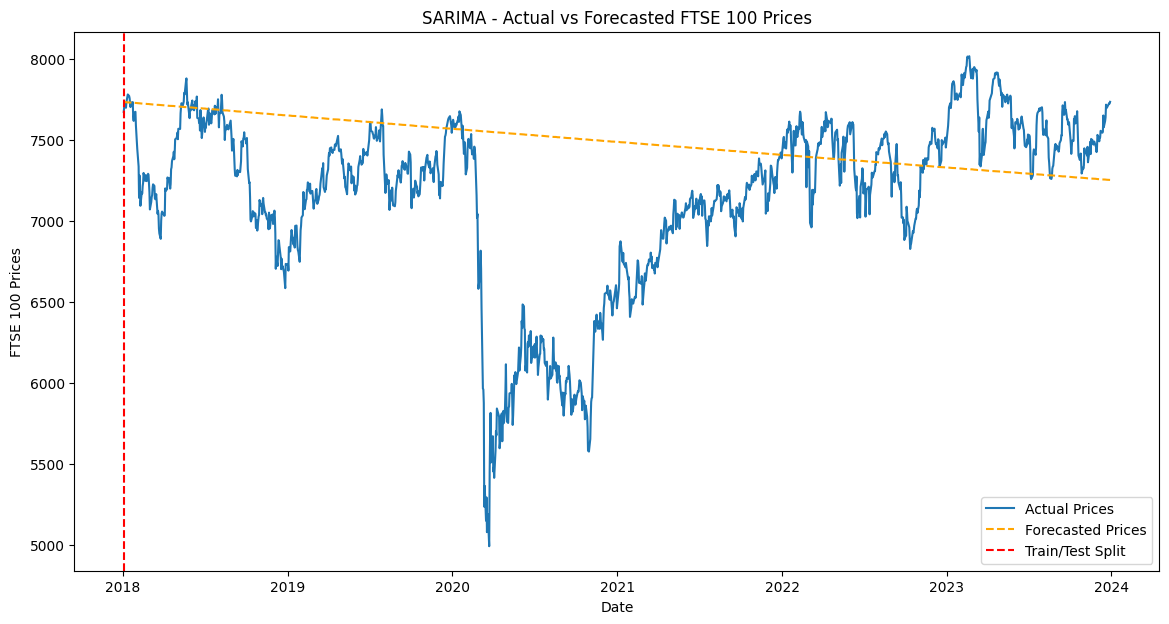

RMSE for Prices: 671.9193407689921
MAE for Prices: 478.3485816904576


In [119]:
# Actual vs Forecasted Prices (Train + Test Data)
plt.figure(figsize=(14, 7))
plt.plot(prices, label='Actual Prices')
plt.plot(actual_prices.index, forecasted_prices, label='Forecasted Prices (Test)', linestyle='--', color='orange')

# Add a vertical dashed line to indicate the train-test split
plt.axvline(x=actual_prices.index[0], color='red', linestyle='--', label='Train/Test Split')

# Set the x-axis limits dynamically to start where the data starts
plt.xlim(['2003', max(returns.index)])

plt.title('SARIMA - Actual vs Forecasted FTSE 100 Prices (Train + Test Data)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Prices')
plt.legend()
plt.show()

# Visualization of Forecasted vs Actual Prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices.index, actual_prices, label='Actual Prices')
plt.plot(actual_prices.index, forecasted_prices, label='Forecasted Prices', linestyle='--', color='orange')
plt.axvline(x=actual_prices.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('SARIMA - Actual vs Forecasted FTSE 100 Prices')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Prices')
plt.legend()
plt.show()

print(f"RMSE for Prices: {rmse_prices}")
print(f"MAE for Prices: {mae_prices}")


### SARIMA Model for Returns

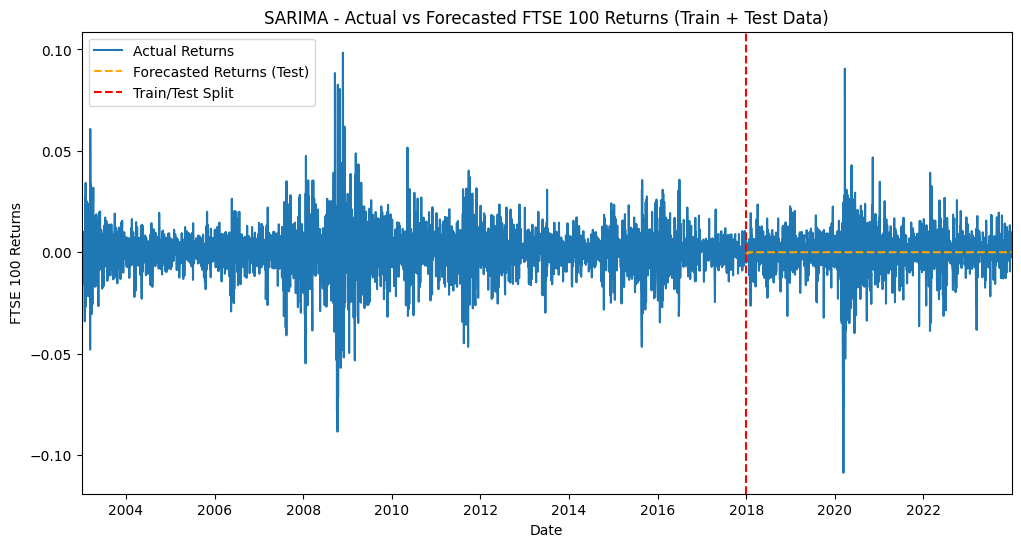

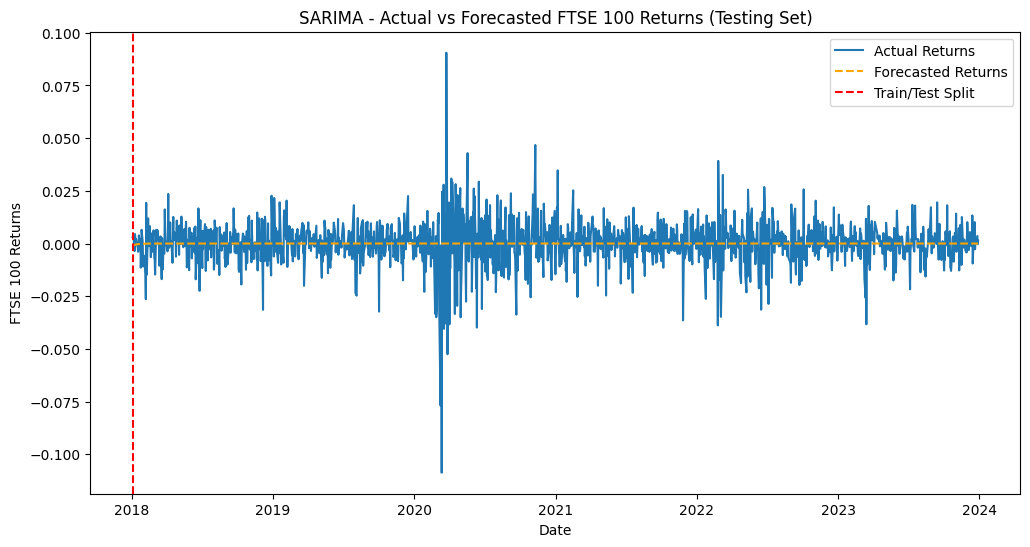

RMSE for Returns: 0.010674719651850934
MAE for Returns: 0.007106259399078576


In [120]:
# Actual vs Forecasted Returns (Train + Test Data)
plt.figure(figsize=(12, 6))
plt.plot(returns, label='Actual Returns')
plt.plot(actual_returns.index, forecasted_returns, label='Forecasted Returns (Test)', linestyle='--', color='orange')
plt.axvline(x=actual_returns.index[0], color='red', linestyle='--', label='Train/Test Split')

# Set the x-axis limits dynamically to start where the data starts
plt.xlim(['2003', max(returns.index)])

# Add labels and legend
plt.title('SARIMA - Actual vs Forecasted FTSE 100 Returns (Train + Test Data)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Returns')
plt.legend()
plt.show()

# Visualization of Forecasted vs Actual Returns
plt.figure(figsize=(12, 6))
plt.plot(actual_returns.index, actual_returns, label='Actual Returns')
plt.plot(actual_returns.index, forecasted_returns, label='Forecasted Returns', linestyle='--', color='orange')
plt.axvline(x=actual_returns.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('SARIMA - Actual vs Forecasted FTSE 100 Returns (Testing Set)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Returns')
plt.legend()
plt.show()

print(f"RMSE for Returns: {rmse_returns}")
print(f"MAE for Returns: {mae_returns}")

## 9. SARIMAX Model


In [121]:
split_index = int(len(prices) * 0.7)

# Training and testing for Prices
train_prices = prices[:split_index]
test_prices = prices[split_index:]

# Training and testing for Returns
train_returns = returns[:split_index]
test_returns = returns[split_index:]

# Exogenous variables for Prices
train_exog_prices = exog_prices[:split_index]
test_exog_prices = exog_prices[split_index:]

# Exogenous variables for Returns
train_exog_returns = exog_returns[:split_index]
test_exog_returns = exog_returns[split_index:]

In [122]:
train_prices, train_exog_prices = train_prices.align(train_exog_prices, join='inner', axis=0)
test_prices, test_exog_prices = test_prices.align(test_exog_prices, join='inner', axis=0)

train_returns, train_exog_returns = train_returns.align(train_exog_returns, join='inner', axis=0)
test_returns, test_exog_returns = test_returns.align(test_exog_returns, join='inner', axis=0)


In [123]:
# SARIMAX for Prices
sarimax_model_prices = sm.tsa.SARIMAX(train_prices, exog=train_exog_prices, order=(1, 1, 1), seasonal_order=(1, 1, 1, 21))
sarimax_result_prices = sarimax_model_prices.fit()

# SARIMAX for Returns
sarimax_model_returns = sm.tsa.SARIMAX(train_returns, exog=train_exog_returns, order=(1, 1, 1), seasonal_order=(1, 1, 1, 21))
sarimax_result_returns = sarimax_model_returns.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [124]:
# Forecast on the test data

# Forecast Prices
forecast_prices = sarimax_result_prices.get_forecast(steps=len(test_prices), exog=test_exog_prices)
forecasted_prices = forecast_prices.predicted_mean

# Forecast Returns
forecast_returns = sarimax_result_returns.get_forecast(steps=len(test_returns), exog=test_exog_returns)
forecasted_returns = forecast_returns.predicted_mean

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [125]:
# Evaluate the Model

# Evaluation for Prices
rmse_prices = np.sqrt(mean_squared_error(test_prices, forecasted_prices))
mae_prices = mean_absolute_error(test_prices, forecasted_prices)

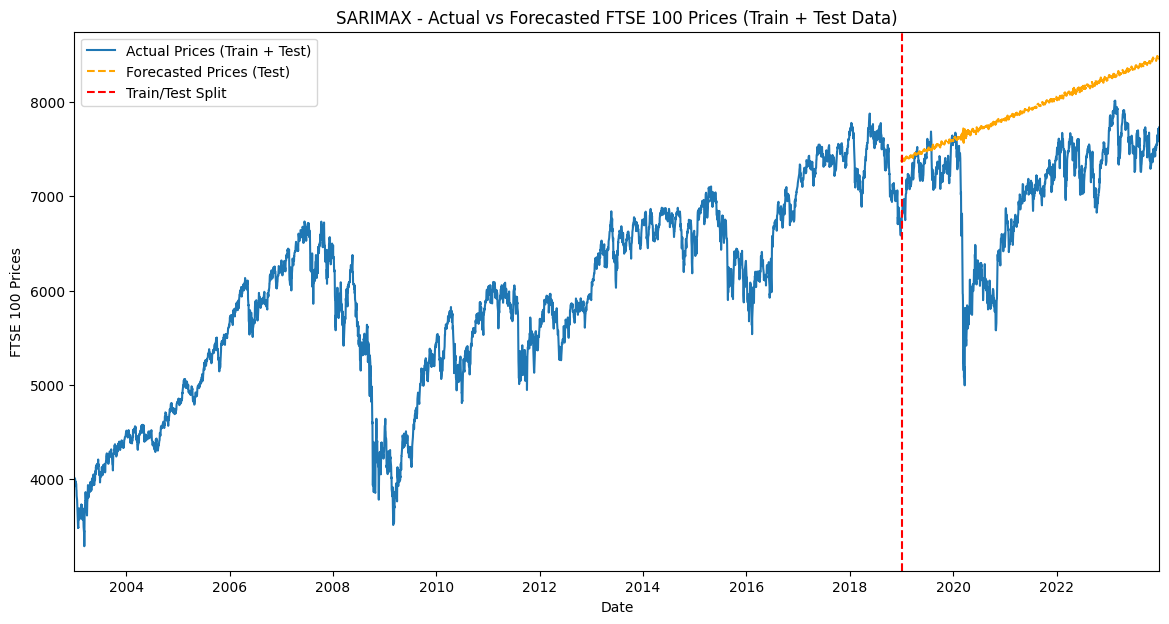

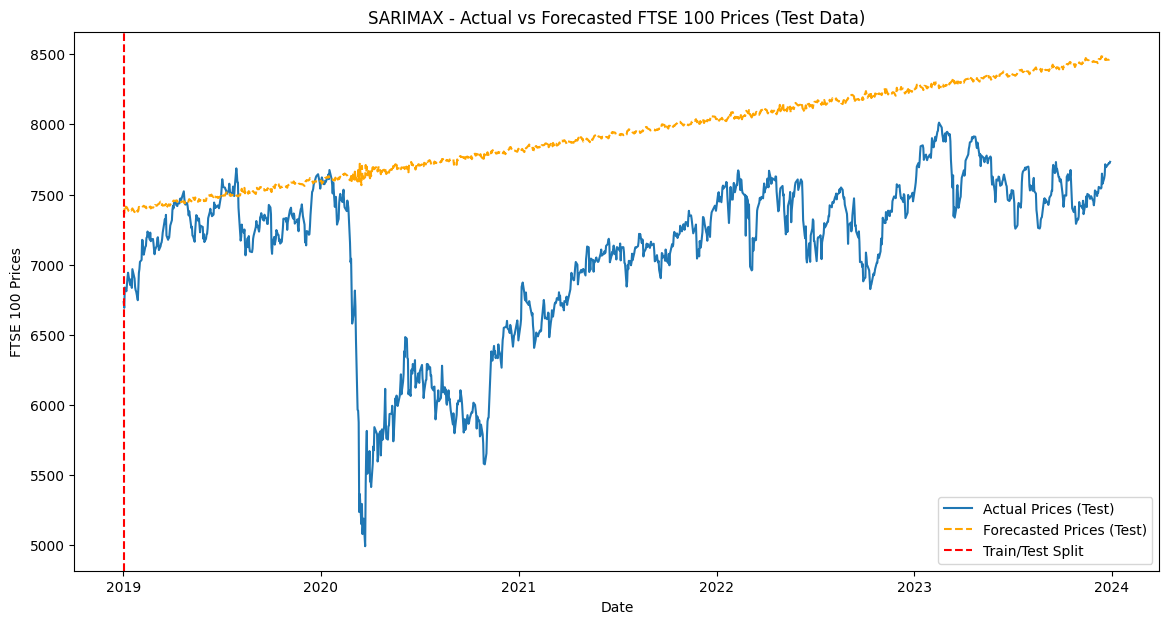

RMSE for Prices: 974.6283743868728
MAE for Prices: 828.9561502744745


In [126]:
#  SARIMAX vs Actual Data Forecast Returns (Train + Test Data)
plt.figure(figsize=(14, 7))
plt.plot(prices.index, prices, label='Actual Prices (Train + Test)')
plt.plot(test_prices.index, forecasted_prices, label='Forecasted Prices (Test)', linestyle='--', color='orange')
plt.axvline(x=test_prices.index[0], color='red', linestyle='--', label='Train/Test Split')

# Set the x-axis limits dynamically to start where the data starts
plt.xlim(['2003', max(returns.index)])

# Add labels and legend
plt.title('SARIMAX - Actual vs Forecasted FTSE 100 Prices (Train + Test Data)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Prices')
plt.legend()
plt.show()

# Plot actual vs forecasted prices
plt.figure(figsize=(14, 7))
plt.plot(test_prices.index, test_prices, label='Actual Prices (Test)')
plt.plot(test_prices.index, forecasted_prices, label='Forecasted Prices (Test)', linestyle='--', color='orange')
plt.axvline(x=test_prices.index[0], color='red', linestyle='--', label='Train/Test Split')

plt.title('SARIMAX - Actual vs Forecasted FTSE 100 Prices (Test Data)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Prices')
plt.legend()
plt.show()

print(f"RMSE for Prices: {rmse_prices}")
print(f"MAE for Prices: {mae_prices}")


### SRAIMAX Model for Returns

In [127]:
# Evaluation for Returns
rmse_returns = np.sqrt(mean_squared_error(test_returns, forecasted_returns))
mae_returns = mean_absolute_error(test_returns, forecasted_returns)

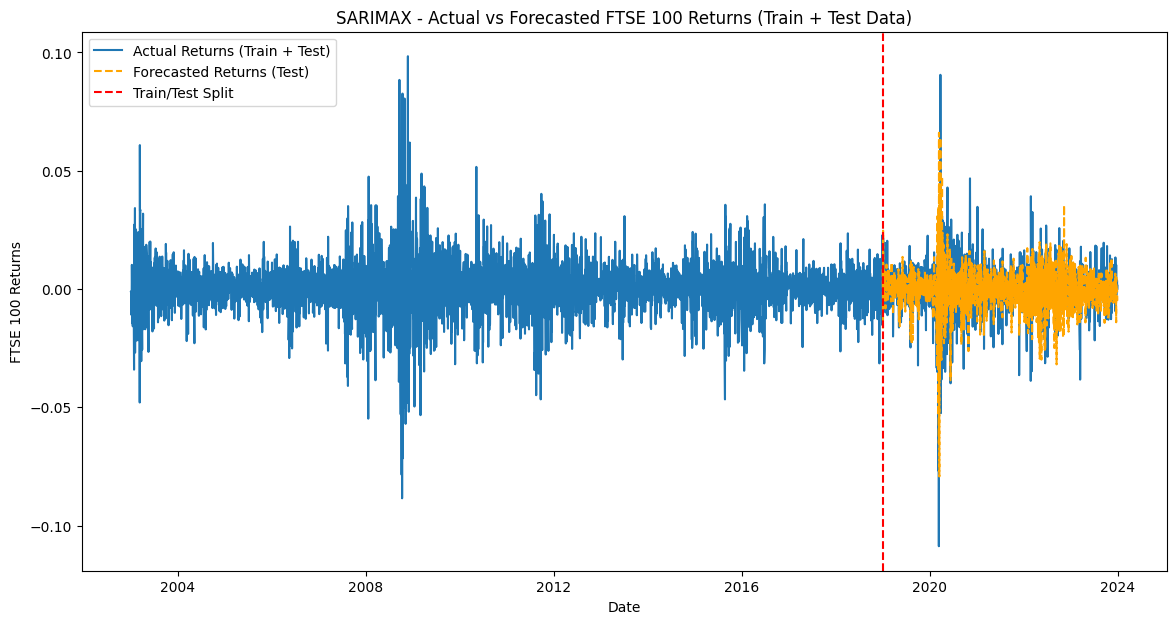

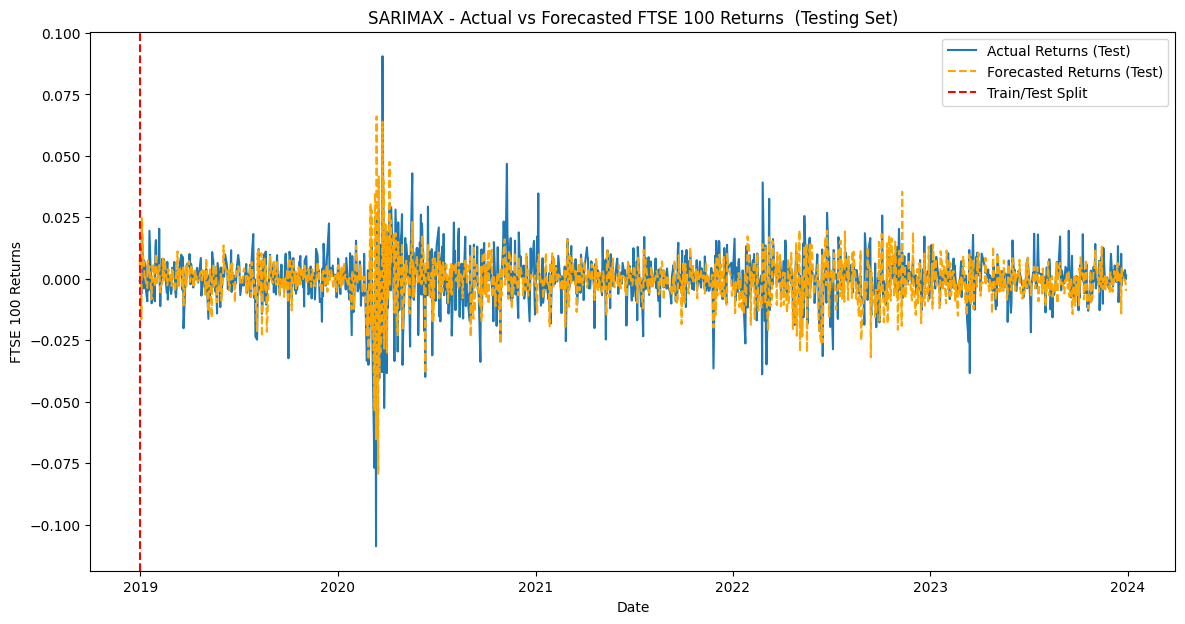

RMSE for Returns: 0.009759158125137954
MAE for Returns: 0.00709834627951638


In [128]:
# Plot full actual vs forecasted returns (train + test)
plt.figure(figsize=(14, 7))
plt.plot(returns.index, returns, label='Actual Returns (Train + Test)')
plt.plot(test_returns.index, forecasted_returns, label='Forecasted Returns (Test)', linestyle='--', color='orange')

plt.axvline(x=test_returns.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('SARIMAX - Actual vs Forecasted FTSE 100 Returns (Train + Test Data)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Returns')
plt.legend()
plt.show()



# Plot actual vs forecasted returns
plt.figure(figsize=(14, 7))
plt.plot(test_returns.index, test_returns, label='Actual Returns (Test)')
plt.plot(test_returns.index, forecasted_returns, label='Forecasted Returns (Test)', linestyle='--', color='orange')
plt.axvline(x=test_returns.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('SARIMAX - Actual vs Forecasted FTSE 100 Returns  (Testing Set)')
plt.xlabel('Date')
plt.ylabel('FTSE 100 Returns')
plt.legend()
plt.show()

print(f"RMSE for Returns: {rmse_returns}")
print(f"MAE for Returns: {mae_returns}")